In [1]:
import pandas as pd
import numpy as np
import os
import re

# Set working directory
if not "/data/tables" in os.getcwd():
    os.chdir("../data/curated")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
import functools
from sklearn import linear_model


spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/

Using Python version 3.9.12 (main, Apr  4 2022 05:22:27)
Spark context Web UI available at http://192.168.1.6:4041
Spark context available as 'sc' (master = local[*], app id = local-1664787632550).
SparkSession available as 'spark'.


# Read dataset

In [ ]:
final = pd.read_parquet('./final_merchant_statistics')
final = final.toPandas()
final

## If code above cannot read the folder, run this code below

In [29]:
# explicit function
def unionAll(dfs):
    return functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)

path = "./final_merchant_statistics/final_merchant_statistics/"
list_dir = os.listdir(path)
list_dir = [i for i in list_dir if i[0]=="p"]
list_files = list_dir

final = spark.read.parquet(path + list_files[0])
for i in list_files[1:]:
    tmp = spark.read.parquet(path + i)
    final = unionAll([final, tmp])
    
final = final.toPandas()
final

,merchant_abn,name,tags,tag,revenue_level,take_rate,sales_revenue,no_orders,avg_daily_rev,avg_value_per_order,avg_daily_order,avg_daily_commission,avg_commission_per_order,sa2_region_count,median_customer_income,returning_customer,mean_spending,std_spending,vip_customer
0,10023283211,Felis Limited,"((furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",e,0.18,7.032777e+05,3261.0,1162.442498,215.663205,5.390083,2.092396,0.388194,1717.0,800.259547,11.0,231.951752,155.424439,137.0
1,10346855916,Odio Institute,"((equipment, tool, furniture, and appliance r...","equipment, tool, furniture, and appliance ren...",b,3.57,6.775178e+03,6.0,11.198642,1129.196413,0.009917,0.399792,40.312312,7.0,795.400000,0.0,1129.196413,717.988423,0.0
2,10385163239,Sed Et Company,"([florists supplies, nursery stock, and flower...","florists supplies, nursery stock, and flowers",a,6.61,2.519346e+04,74.0,41.642088,340.452204,0.122314,2.752542,22.503891,132.0,800.853287,0.0,345.115933,203.496326,3.0
3,10648956813,Proin Nisl Institute,"[(computeRs, computer peripheral equipment, an...","computers, computer peripheral equipment, and ...",a,6.66,1.419600e+06,21981.0,2346.446772,64.583063,36.332231,156.273355,4.301232,2208.0,835.366766,1574.0,98.720466,57.083817,710.0
4,10714068705,Sollicitudin Commodo Ipsum Industries,"([furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",c,2.51,4.355100e+05,3438.0,719.851158,126.675378,5.682645,18.068264,3.179552,1715.0,802.506127,10.0,135.209547,113.737044,145.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,98850646791,Sapien Industries,"[[hobby, toy and game shops], [b], [take rate:...","hobby, toy and game shops",b,3.66,5.965319e+03,4.0,9.860032,1491.329779,0.006612,0.360877,54.582670,5.0,855.125000,0.0,1491.329779,312.966965,0.0
4022,98973094975,Ornare Fusce Inc.,"[(hobby, toy and game shops), (a), (take rate:...","hobby, toy and game shops",a,5.98,6.820456e+06,54611.0,11273.480318,124.891608,90.266116,674.154123,7.468518,2222.0,826.758965,9590.0,316.347662,206.620943,945.0
4023,99009287608,Nunc Risus LLP,"([computer programming , data processing, and ...","computer programming , data processing, and in...",b,3.15,4.803691e+04,260.0,79.399848,184.757339,0.429752,2.501095,5.819856,419.0,774.127507,0.0,185.470688,132.675435,10.0
4024,99420575685,Facilisi Consulting,"[[art dealers and galleries], [b], [take rate:...",art dealers and galleries,b,4.78,3.694443e+03,3.0,6.106517,1231.480862,0.004959,0.291891,58.864785,6.0,713.750000,0.0,1231.480862,461.033395,0.0


In [31]:
final[final['name'] == 'Erat Vitae LLP']

,merchant_abn,name,tags,tag,revenue_level,take_rate,sales_revenue,no_orders,avg_daily_rev,avg_value_per_order,avg_daily_order,avg_daily_commission,avg_commission_per_order,sa2_region_count,median_customer_income,returning_customer,mean_spending,std_spending,vip_customer
3143,24852446429,Erat Vitae LLP,"[(florists supplies, nursery stock, and floWer...","florists supplies, nursery stock, and flowers",c,2.94,8.696260e+06,287490.0,14373.983615,30.248913,475.190083,422.595118,0.889318,2222.0,824.007743,24068.0,361.140369,127.399516,805.0


### missing value, NaN

In [3]:
final = final.fillna(0) 

# Linear Combination Modeling Method

#### Which features should BNPL firms consider for determining which merchants should or should not accepted?

1. Finance / cash flow (take_rate, revenue_level) -> average daily commision = average daily revenue * take rate
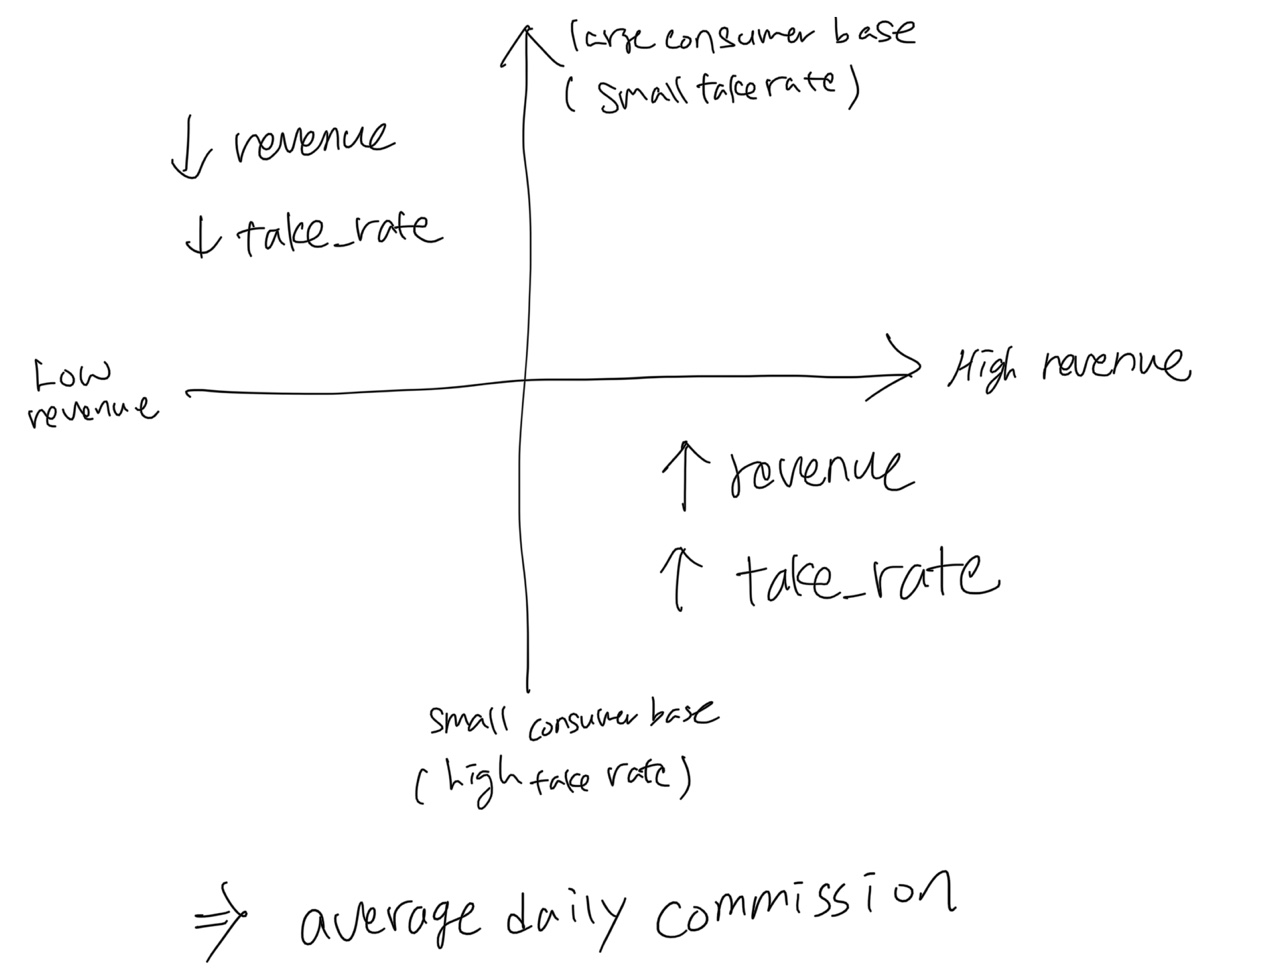

Ultimately, we want the merchants with high renevue with high take rates.

We have average daily commission metric that could explain those both.

Hence, 'average daily commission' will be weighted most.

2. stability of merchant (returning_customer,std_spending,vip_customer)
When deciding which merchants can be trustworthy, we should also consider if it has steady and stable sales, customers, and revenue.

Hence, I used these metrics('returning_customer','std_spending','vip_customer') to find stability.

    1) Used K-means clustering with 3 variables above. -> tried K = 3, but K=2 was better. (not a big difference -> simple is best)
        Here, cluster '1' is the group with high stability.
        
    2) Used Random Forest to make the degree of stability from 0 to 1.

This will be weighted after 'commission'.

# Relationship between take_rate and revenue_level

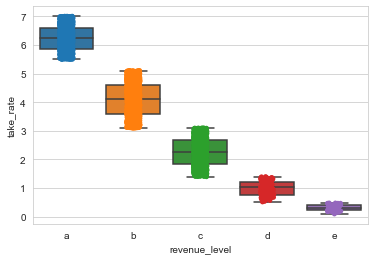

In [4]:
x = final['take_rate']
y = final['revenue_level']
sns.set_style('whitegrid')
ax= sns.boxplot(x=y,y=x,data=final, order = ["a","b","c","d","e"])
ax = sns.stripplot(x=y, y=x,data=final, order = ["a","b","c","d","e"])

Ultimately, we want the merchants with high renevue with high take rates.

We have average daily commission metric that could explain those both.

Hence, 'average daily commission' will be weighted most.

# Stability 

When deciding which merchants can be trustworthy, we should also consider if it has steady and stable sales, customers, and revenue.

Hence, I used these metrics('returning_customer','std_spending','vip_customer') to find stability.

First, I divided the groups into 2 with k-means clustering.

Here, cluster '1' is the group with high stability.

Then, I used random forest classifiers to show the probability of showing stability from 0 to 1.

This will be weighted after 'commission'.

In [5]:
final_stability = final[['returning_customer','std_spending','vip_customer']]
final_stability = final_stability.fillna(0)

### K-means Clustering

In [6]:
from sklearn.cluster import KMeans
import numpy as np
X = np.array(final_stability)
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=100, tol=0.01, random_state=0).fit(X)
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [7]:
from collections import Counter
Counter(kmeans.labels_)

Counter({0: 3998, 1: 28})

In [8]:
final_stability["cluster"] = kmeans.labels_
final_stability

,returning_customer,std_spending,vip_customer,cluster
0,11.0,155.424439,137.0,0
1,0.0,717.988423,0.0,0
2,0.0,203.496326,3.0,0
3,1574.0,57.083817,710.0,0
4,10.0,113.737044,145.0,0
...,...,...,...,...
4021,0.0,312.966965,0.0,0
4022,9590.0,206.620943,945.0,1
4023,0.0,132.675435,10.0,0
4024,0.0,461.033395,0.0,0


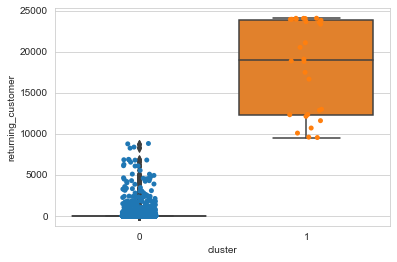

In [9]:
x = final_stability['returning_customer']
y = final_stability['cluster']
sns.set_style('whitegrid')
ax= sns.boxplot(x=y,y=x,data=final_stability, order = [0,1])
ax = sns.stripplot(x=y, y=x,data=final_stability, order = [0,1])

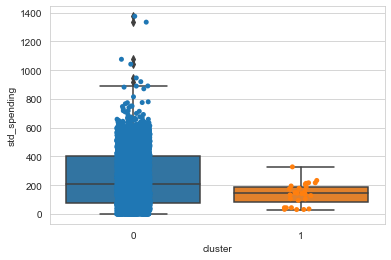

In [10]:
x = final_stability['std_spending']
y = final_stability['cluster']
sns.set_style('whitegrid')
ax= sns.boxplot(x=y,y=x,data=final_stability, order = [0,1])
ax = sns.stripplot(x=y, y=x,data=final_stability, order = [0,1])

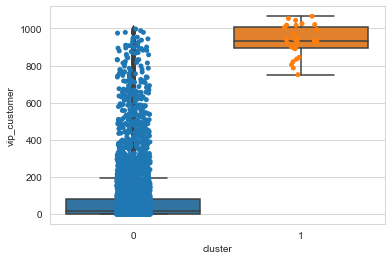

In [11]:

x = final_stability['vip_customer']
y = final_stability['cluster']
sns.set_style('whitegrid')
ax= sns.boxplot(x=y,y=x,data=final_stability, order = [0,1])
ax = sns.stripplot(x=y, y=x,data=final_stability, order = [0,1])

In [12]:
final["cluster"] = kmeans.labels_
final

,merchant_abn,name,tags,tag,revenue_level,take_rate,sales_revenue,no_orders,avg_daily_rev,avg_value_per_order,avg_daily_order,avg_daily_commission,avg_commission_per_order,sa2_region_count,median_customer_income,returning_customer,mean_spending,std_spending,vip_customer,cluster
0,10023283211,Felis Limited,"((furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",e,0.18,7.032777e+05,3261.0,1162.442498,215.663205,5.390083,2.092396,0.388194,1717.0,800.259547,11.0,231.951752,155.424439,137.0,0
1,10346855916,Odio Institute,"((equipment, tool, furniture, and appliance r...","equipment, tool, furniture, and appliance ren...",b,3.57,6.775178e+03,6.0,11.198642,1129.196413,0.009917,0.399792,40.312312,7.0,795.400000,0.0,1129.196413,717.988423,0.0,0
2,10385163239,Sed Et Company,"([florists supplies, nursery stock, and flower...","florists supplies, nursery stock, and flowers",a,6.61,2.519346e+04,74.0,41.642088,340.452204,0.122314,2.752542,22.503891,132.0,800.853287,0.0,345.115933,203.496326,3.0,0
3,10648956813,Proin Nisl Institute,"[(computeRs, computer peripheral equipment, an...","computers, computer peripheral equipment, and ...",a,6.66,1.419600e+06,21981.0,2346.446772,64.583063,36.332231,156.273355,4.301232,2208.0,835.366766,1574.0,98.720466,57.083817,710.0,0
4,10714068705,Sollicitudin Commodo Ipsum Industries,"([furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",c,2.51,4.355100e+05,3438.0,719.851158,126.675378,5.682645,18.068264,3.179552,1715.0,802.506127,10.0,135.209547,113.737044,145.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,98850646791,Sapien Industries,"[[hobby, toy and game shops], [b], [take rate:...","hobby, toy and game shops",b,3.66,5.965319e+03,4.0,9.860032,1491.329779,0.006612,0.360877,54.582670,5.0,855.125000,0.0,1491.329779,312.966965,0.0,0
4022,98973094975,Ornare Fusce Inc.,"[(hobby, toy and game shops), (a), (take rate:...","hobby, toy and game shops",a,5.98,6.820456e+06,54611.0,11273.480318,124.891608,90.266116,674.154123,7.468518,2222.0,826.758965,9590.0,316.347662,206.620943,945.0,1
4023,99009287608,Nunc Risus LLP,"([computer programming , data processing, and ...","computer programming , data processing, and in...",b,3.15,4.803691e+04,260.0,79.399848,184.757339,0.429752,2.501095,5.819856,419.0,774.127507,0.0,185.470688,132.675435,10.0,0
4024,99420575685,Facilisi Consulting,"[[art dealers and galleries], [b], [take rate:...",art dealers and galleries,b,4.78,3.694443e+03,3.0,6.106517,1231.480862,0.004959,0.291891,58.864785,6.0,713.750000,0.0,1231.480862,461.033395,0.0,0


### so, we've tried to use k-means clustering but it didn't perform the clustering well as we anticipated.

### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
# Train
X = final[['returning_customer','std_spending','vip_customer']].fillna(0)
Y = final["cluster"]

forest = RandomForestClassifier(n_estimators=100)
forest.fit(X, Y)
 
# Predict
pred = forest.predict_proba(X)


In [14]:
pred = [pred[i][1] for i in range(pred.shape[0])]
pred

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.73,
 0.0,
 0.01,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

In [15]:
final["stability"] = pred
final

,merchant_abn,name,tags,tag,revenue_level,take_rate,sales_revenue,no_orders,avg_daily_rev,avg_value_per_order,...,avg_daily_commission,avg_commission_per_order,sa2_region_count,median_customer_income,returning_customer,mean_spending,std_spending,vip_customer,cluster,stability
0,10023283211,Felis Limited,"((furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",e,0.18,7.032777e+05,3261.0,1162.442498,215.663205,...,2.092396,0.388194,1717.0,800.259547,11.0,231.951752,155.424439,137.0,0,0.00
1,10346855916,Odio Institute,"((equipment, tool, furniture, and appliance r...","equipment, tool, furniture, and appliance ren...",b,3.57,6.775178e+03,6.0,11.198642,1129.196413,...,0.399792,40.312312,7.0,795.400000,0.0,1129.196413,717.988423,0.0,0,0.00
2,10385163239,Sed Et Company,"([florists supplies, nursery stock, and flower...","florists supplies, nursery stock, and flowers",a,6.61,2.519346e+04,74.0,41.642088,340.452204,...,2.752542,22.503891,132.0,800.853287,0.0,345.115933,203.496326,3.0,0,0.00
3,10648956813,Proin Nisl Institute,"[(computeRs, computer peripheral equipment, an...","computers, computer peripheral equipment, and ...",a,6.66,1.419600e+06,21981.0,2346.446772,64.583063,...,156.273355,4.301232,2208.0,835.366766,1574.0,98.720466,57.083817,710.0,0,0.00
4,10714068705,Sollicitudin Commodo Ipsum Industries,"([furniture, home furnishings and equipment sh...","furniture, home furnishings and equipment shop...",c,2.51,4.355100e+05,3438.0,719.851158,126.675378,...,18.068264,3.179552,1715.0,802.506127,10.0,135.209547,113.737044,145.0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,98850646791,Sapien Industries,"[[hobby, toy and game shops], [b], [take rate:...","hobby, toy and game shops",b,3.66,5.965319e+03,4.0,9.860032,1491.329779,...,0.360877,54.582670,5.0,855.125000,0.0,1491.329779,312.966965,0.0,0,0.00
4022,98973094975,Ornare Fusce Inc.,"[(hobby, toy and game shops), (a), (take rate:...","hobby, toy and game shops",a,5.98,6.820456e+06,54611.0,11273.480318,124.891608,...,674.154123,7.468518,2222.0,826.758965,9590.0,316.347662,206.620943,945.0,1,0.83
4023,99009287608,Nunc Risus LLP,"([computer programming , data processing, and ...","computer programming , data processing, and in...",b,3.15,4.803691e+04,260.0,79.399848,184.757339,...,2.501095,5.819856,419.0,774.127507,0.0,185.470688,132.675435,10.0,0,0.00
4024,99420575685,Facilisi Consulting,"[[art dealers and galleries], [b], [take rate:...",art dealers and galleries,b,4.78,3.694443e+03,3.0,6.106517,1231.480862,...,0.291891,58.864785,6.0,713.750000,0.0,1231.480862,461.033395,0.0,0,0.00


In [16]:
final[final["stability"] > 0.5]

,merchant_abn,name,tags,tag,revenue_level,take_rate,sales_revenue,no_orders,avg_daily_rev,avg_value_per_order,...,avg_daily_commission,avg_commission_per_order,sa2_region_count,median_customer_income,returning_customer,mean_spending,std_spending,vip_customer,cluster,stability
148,49891706470,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",tent and awning shops,a,5.80,7.171594e+06,247526.0,11853.874899,28.973095,...,687.524744,1.680440,2222.0,824.025844,24037.0,297.848422,104.335316,751.0,1,0.73
495,89726005175,Est Nunc Consulting,"((tent and awning shops), (a), (take rate: 6.01))",tent and awning shops,a,6.01,8.908718e+06,215889.0,14725.153285,41.265269,...,884.981712,2.480043,2222.0,824.004285,23930.0,369.978726,142.197682,844.0,1,0.97
604,43186523025,Lorem Ipsum Sodales Industries,"([florists supplies, nurSery stock, and flower...","florists supplies, nursery stock, and flowers",b,4.47,9.041891e+06,200846.0,14945.274899,45.019026,...,668.053788,2.012350,2222.0,824.024733,23814.0,375.556210,148.866575,835.0,1,0.95
748,96152467973,Rhoncus Donec Associates,"[[tent and awning shops], [b], [take rate: 4.45]]",tent and awning shops,b,4.45,1.400612e+06,65745.0,2315.060589,21.303698,...,103.020196,0.948015,2222.0,826.276666,12351.0,62.213461,43.235522,1044.0,1,0.99
853,49505931725,Suspendisse Ac Associates,"([digital goods: books, movies, music], [b], [...","digital goods: books, movies, music",b,4.70,7.180616e+06,68240.0,11868.787571,105.225916,...,557.833016,4.945618,2222.0,821.218935,12986.0,316.521929,194.301590,994.0,1,0.93
879,60956456424,Ultricies Dignissim LLP,"([gift, card, Novelty, and souvenir shops], [b...","gift, card, novelty, and souvenir shops",b,4.69,8.026971e+06,90705.0,13267.720204,88.495350,...,622.256078,4.150432,2219.0,824.538699,17480.0,341.587758,178.640692,905.0,1,1.00
1084,48534649627,Dignissim Maecenas Foundation,"[[opticians, oPtical goods, and eyeglasses], [...","opticians, optical goods, and eyeglasses",a,6.64,9.406000e+06,65519.0,15547.107649,143.561412,...,1032.327948,9.532478,2222.0,825.442153,12320.0,417.617552,327.399047,1066.0,1,0.91
1243,17324645993,Eget Metus In Corporation,"([tent and awning shops], [a], [take rate: 5.73])",tent and awning shops,a,5.73,8.792994e+05,56574.0,1453.387460,15.542465,...,83.279101,0.890583,2211.0,825.808692,10085.0,40.316342,30.812987,1017.0,1,0.98
1247,19933438190,Dui Nec Corporation,"[[tent and awning shops], [c], [take rate: 2.22]]",tent and awning shops,c,2.22,9.225278e+05,59012.0,1524.839315,15.632885,...,33.851433,0.347050,2222.0,827.079804,10702.0,41.858877,31.569964,1021.0,1,1.00
1327,45629217853,Lacus Consulting,"[[gift, Card, novelty, and souvenir shops], [a...","gift, card, novelty, and souvenir shops",a,6.98,8.384278e+06,216673.0,13858.310672,38.695536,...,967.310085,2.700948,2222.0,823.997416,23944.0,348.184301,159.318325,926.0,1,0.97


# standardisation with min-max scaling(normalisation)

#### Why using min-max scaling: It is one of the method of standardisation, and since ranking doesn't have negative value, min-max scaling is suitable because it shows from 0 to 1. And also, it can cover all the continuous variable.
#### Min-max scaling : Min-max normalization (usually called feature scaling) performs a linear transformation on the original data. This technique gets all the scaled data in the range (0, 1). The formula to achieve this is the following: Min-max normalization preserves the relationships among the original data values.

In [17]:
final['revenue_level'] = np.where(final['revenue_level'] == "a", 1,
                                 np.where(final['revenue_level'] == "b", 2,
                                          np.where(final['revenue_level'] == "c", 3,
                                                   np.where(final['revenue_level'] == "d", 4,5))))

In [18]:
# min_max_scale
def min_max(data):
    #data = [i for i in data if np.isnan(i) == False]
    if np.max(data) == np.min(data) : return np.array(data)
    else : return (data - np.min(data)) / (np.max(data) - np.min(data))

In [19]:
final = final[['merchant_abn','name','revenue_level',\
       'no_orders', 'avg_value_per_order',\
       'avg_daily_order', 'avg_daily_commission', 'avg_commission_per_order',\
       'sa2_region_count', 'median_customer_income',\
       'mean_spending','stability']]

In [20]:
list_name = ['revenue_level',\
       'no_orders', 'avg_value_per_order',\
       'avg_daily_order', 'avg_daily_commission', 'avg_commission_per_order',\
       'sa2_region_count', 'median_customer_income',\
       'mean_spending','stability']

for i in list_name:
    final[i] = min_max(final[i])
    
final

C:\Users\tommy\AppData\Local\Temp\ipykernel_33012\2622239204.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final[i] = min_max(final[i])


,merchant_abn,name,revenue_level,no_orders,avg_value_per_order,avg_daily_order,avg_daily_commission,avg_commission_per_order,sa2_region_count,median_customer_income,mean_spending,stability
0,10023283211,Felis Limited,1.00,0.011343,0.104866,0.011343,0.002027,0.002952,0.772727,0.177402,0.112786,0.00
1,10346855916,Odio Institute,0.25,0.000021,0.549072,0.000021,0.000387,0.306524,0.003150,0.176325,0.549072,0.00
2,10385163239,Sed Et Company,0.00,0.000257,0.165545,0.000257,0.002666,0.171114,0.059406,0.177534,0.167813,0.00
3,10648956813,Proin Nisl Institute,0.00,0.076458,0.031404,0.076458,0.151380,0.032705,0.993699,0.185185,0.048003,0.00
4,10714068705,Sollicitudin Commodo Ipsum Industries,0.50,0.011959,0.061596,0.011959,0.017502,0.024176,0.771827,0.177900,0.065746,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
4021,98850646791,Sapien Industries,0.25,0.000014,0.725159,0.000014,0.000350,0.415032,0.002250,0.189565,0.725159,0.00
4022,98973094975,Ornare Fusce Inc.,0.00,0.189958,0.060729,0.189958,0.653043,0.056789,1.000000,0.183277,0.153824,0.83
4023,99009287608,Nunc Risus LLP,0.25,0.000904,0.089838,0.000904,0.002423,0.044253,0.188569,0.171609,0.090185,0.00
4024,99420575685,Facilisi Consulting,0.25,0.000010,0.598807,0.000010,0.000283,0.447592,0.002700,0.158225,0.598807,0.00


Here, 'take_rate', 'avg_daily_rev','returning_customer','std_spending','vip_customer' is excluded, because it is dependent variable to the 'avg_daily_commission' and 'stability'.

# Including metrics: Commision + Stability

In [21]:
final.columns

Index(['merchant_abn', 'name', 'revenue_level', 'no_orders',
       'avg_value_per_order', 'avg_daily_order', 'avg_daily_commission',
       'avg_commission_per_order', 'sa2_region_count',
       'median_customer_income', 'mean_spending', 'stability'],
      dtype='object')

In [22]:
final['final_score'] = final.iloc[:,2:].sum(axis = 1) 
final = final.sort_values(by = "final_score", ascending = False).reset_index(drop = True)

C:\Users\tommy\AppData\Local\Temp\ipykernel_33012\2572360506.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final['final_score'] = final.iloc[:,2:].sum(axis = 1)


In [23]:
final["rank"] = range(1,(final.shape[0])+1)
final

,merchant_abn,name,revenue_level,no_orders,avg_value_per_order,avg_daily_order,avg_daily_commission,avg_commission_per_order,sa2_region_count,median_customer_income,mean_spending,stability,final_score,rank
0,24852446429,Erat Vitae LLP,0.5,1.000000,0.014709,1.000000,0.409361,0.006762,1.0,0.182667,0.175604,0.97,5.259103,1
1,86578477987,Leo In Consulting,0.0,0.943094,0.017105,0.943094,0.981954,0.017199,1.0,0.182666,0.192592,0.97,5.247704,2
2,64203420245,Pede Nonummy Corp.,0.5,0.907092,0.014077,0.907092,0.345707,0.006296,1.0,0.182666,0.152440,0.91,4.925370,3
3,45629217853,Lacus Consulting,0.0,0.753671,0.018816,0.753671,0.937018,0.020537,1.0,0.182664,0.169305,0.97,4.805683,4
4,89726005175,Est Nunc Consulting,0.0,0.750944,0.020065,0.750944,0.857268,0.018858,1.0,0.182666,0.179902,0.97,4.730648,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,80426072728,Massa Non Ante Industries,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,4022
4022,54860127682,Laoreet Posuere Enim Limited,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,4023
4023,10404542215,Consequat Foundation,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,4024
4024,41001282470,Eu Ltd,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,4025


made a ranking system with the commision and stability metrics involved.

# sample weight (in progress)

In [26]:
final["score"] = final['revenue_level'] + final['no_orders'] + final['avg_value_per_order'] + final['avg_daily_order'] + \
        final['avg_daily_commission'] + 4*final['avg_commission_per_order'] + final['sa2_region_count'] + \
        final['median_customer_income'] + final['mean_spending'] + 3*final['stability']

In [27]:
final = final.sort_values(by = "score", ascending = False).reset_index(drop = True)
final

,merchant_abn,name,revenue_level,no_orders,avg_value_per_order,avg_daily_order,avg_daily_commission,avg_commission_per_order,sa2_region_count,median_customer_income,mean_spending,stability,final_score,rank,score
0,86578477987,Leo In Consulting,0.0,0.943094,0.017105,0.943094,0.981954,0.017199,1.0,0.182666,0.192592,0.97,5.247704,2,7.239302
1,24852446429,Erat Vitae LLP,0.5,1.000000,0.014709,1.000000,0.409361,0.006762,1.0,0.182667,0.175604,0.97,5.259103,1,7.219389
2,45629217853,Lacus Consulting,0.0,0.753671,0.018816,0.753671,0.937018,0.020537,1.0,0.182664,0.169305,0.97,4.805683,4,6.807295
3,64203420245,Pede Nonummy Corp.,0.5,0.907092,0.014077,0.907092,0.345707,0.006296,1.0,0.182666,0.152440,0.91,4.925370,3,6.764257
4,46804135891,Suspendisse Dui Corporation,0.5,0.765567,0.015530,0.765567,0.329761,0.007115,1.0,0.182667,0.141953,1.00,4.708161,6,6.729507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4021,78577106740,Donec Consulting,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,4020,0.000000
4022,89618228232,Molestie Tortor Consulting,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,4019,0.000000
4023,28385291716,Vel Arcu Curabitur Inc.,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,4017,0.000000
4024,52524795452,Cras Convallis Associates,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,4021,0.000000


This is a prototype of a ranking system, which gave more weights to the commision and stability metrics.

# Clustering Method: Why it couldn't work in the modelling

#### I tried k = 2~ 8, but as a result, it didn't show the specific difference as k increases and didn't cluster well as we expected.
#### As seen in above with k = 2, it showed "0: 3998, 1: 28".
#### Also, the visualisation shows that it doesn't cluster well to use this in the final ranking model.